# Import necessary modules

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import datetime
import emoji
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# Scrape data from Twitter using Twint

In [ ]:
# Import packages
import twint
import time
import json

# Set up configurations
c = twint.Config()    
c.Store_csv = True # Store to json
c.Since = "2021-01-06 00:00:00" # Set start date for collection
c.Until = "2021-02-17 00:00:00" # Set end date for collection
c.Retweets = True # Include retweets done by user
c.Lang = "en" # Set language
c.Limit = 100000 # Set tweet limit to 100k 
# c.Near = "Singapore" # Set geograpic location 
c.Search = "trump impeachment" # Set search term
c.Output = "../Data/trump_impeachment_all_counties.csv" # Save output in current directory containing python script

# Run
twint.run.Search(c)

# Prepare basic dataframe for further processing

In [60]:
# read raw csv file
df = pd.read_csv('../Data/trump_impeachment_all_counties.csv')

# combine 'date' and 'time' column into one column
df['date_time'] = df[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
df = df.drop(df[df.language != 'en'].index)

# drop unnecessary columns
df.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
df.rename(columns={'tweet':'comment_raw', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
df.insert(2, 'platform', 'twitter')

# rearrange columns to standardise with Instagram data
cols = list(df.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
df2 = df[cols]
df2


,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,1361827317136445442,1103704740809109504,twitter,2021-02-17 07:58:28,0,Will not being convicted end up spurring more ...
1,1361827186399793152,561690193,twitter,2021-02-17 07:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ..."
2,1361826976781197317,1103704740809109504,twitter,2021-02-17 07:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...
3,1361826947316219908,1103704740809109504,twitter,2021-02-17 07:57:00,0,@DrJasonJohnson Will not being convicted end u...
4,1361826793091719171,1103704740809109504,twitter,2021-02-17 07:56:23,0,@davidplouffe Will not being convicted end up ...
...,...,...,...,...,...,...
100079,1354824640938586112,1281704313727922178,twitter,2021-01-29 00:12:20,0,@RoyBlunt As a Mo. citizen I am asking that yo...
100080,1354824634248568834,19553409,twitter,2021-01-29 00:12:18,140,57% of Voters Say Trump Impeachment Will Furth...
100081,1354824563301830656,709378458112172032,twitter,2021-01-29 00:12:01,2,👀 Look at supporters of Sedition? Littl’ Lyin’...
100082,1354824463951360000,1344885199377723392,twitter,2021-01-29 00:11:38,1,# New York Lied about Covid Deaths # Californ...


In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93416 entries, 0 to 100083
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment_id   93416 non-null  int64 
 1   user_id      93416 non-null  int64 
 2   platform     93416 non-null  object
 3   date_time    93416 non-null  object
 4   likes_count  93416 non-null  int64 
 5   comment      93416 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.0+ MB


# Conduct text preprocessing on 'comment_raw' column

In [61]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald', 'trump', 'impeachment', 'amp', 'live', 'update', 'via'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in df2['comment_raw']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text_no_emoji) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed_list.append(text_stopremoved)

# create new columns
df2['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used to vader
df2['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader
df2['comment_processed'] = comment_processed_list # to be used for wordcloud
df3 = df2
df3.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed
0,1361827317136445442,1103704740809109504,twitter,2021-02-17 07:58:28,0,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,"[convicted, end, spurring, less, actions, may,..."
1,1361827186399793152,561690193,twitter,2021-02-17 07:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","[attorney, slams, news, anchor, gets, walks, a..."
2,1361826976781197317,1103704740809109504,twitter,2021-02-17 07:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...,Will not being convicted end up spurring m...,Will not being convicted end up spurring m...,"[convicted, end, spurring, less, actions, may,..."
3,1361826947316219908,1103704740809109504,twitter,2021-02-17 07:57:00,0,@DrJasonJohnson Will not being convicted end u...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."
4,1361826793091719171,1103704740809109504,twitter,2021-02-17 07:56:23,0,@davidplouffe Will not being convicted end up ...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."


# Creating WordClouds
## Basic WordCloud

In [5]:
# create list of words
wordcloud_words = []
for wordlist in df3['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'convicted end spurring less actions may better attorney slams news anchor gets walks away convicted end spurring less actions may better convicted end spurring less actions may better convicted end spurring less actions may better found guilty acting like bitch towards oh well reap sow lawyer resign phila trial lawyers leadership post rift emerges within group knew scam allowed dems use must admit though would like see mitch impeached obstruction lawyer david schoen slams bruce castor incoherenc'

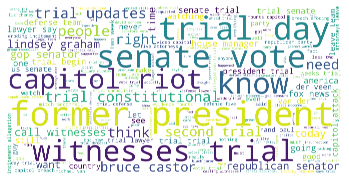

In [6]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("trump_impeachment_no_stopwords.png")

## With background shape

In [15]:
mask = np.array(Image.open("bird2.jpg"))
#photos that have values all zero are not recommended
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [254, 254, 254],
        ...,
        [252, 252, 252],
        [254, 254, 254],
        [254, 254, 254]],

       [[255, 255, 255],
        [255, 255, 255],
        [253, 253, 253],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [239, 239, 239],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[239, 239, 239],
        [235, 235, 235],
        [245, 245, 245],
        ...,
        [243, 243, 243],
        [238, 238, 238],
        [238, 238, 238]],

       [[255, 255, 255],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [249, 249, 249],
        [255, 255, 255],
        [255, 255, 255]]

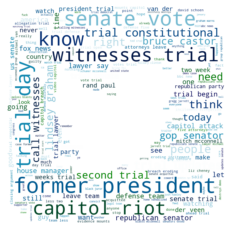

In [28]:
# Generate wordcloud
#method 1 (uses colormap)
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = STOPWORDS, mask=mask, colormap='ocean').generate(wordcloud_string)
# Plot
# plt.figure(figsize=[7,7])
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('twitter_logo_wordcloud.png')

# Vader Sentiment Analysis

In [62]:
# vader sentiment analysis

def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [63]:
df3['vader_compound_emoji'] = df3['comment_cleaned_emoji'].apply(vader_compound_score) 

In [64]:
df3['vader_compound_no_emoji'] = df3['comment_cleaned_no_emoji'].apply(vader_compound_score) 

In [65]:
df3.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed,vader_compound_emoji,vader_compound_no_emoji
0,1361827317136445442,1103704740809109504,twitter,2021-02-17 07:58:28,0,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
1,1361827186399793152,561690193,twitter,2021-02-17 07:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","[attorney, slams, news, anchor, gets, walks, a...",0.0000,0.0000
2,1361826976781197317,1103704740809109504,twitter,2021-02-17 07:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...,Will not being convicted end up spurring m...,Will not being convicted end up spurring m...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
3,1361826947316219908,1103704740809109504,twitter,2021-02-17 07:57:00,0,@DrJasonJohnson Will not being convicted end u...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
4,1361826793091719171,1103704740809109504,twitter,2021-02-17 07:56:23,0,@davidplouffe Will not being convicted end up ...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404


In [66]:
df3.to_csv("trump_impeachment_all_countries_processed.csv")

In [ ]:
plt.hist(df3.vader_score)